In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-player-segmentation/annotations/instances_default.json
/kaggle/input/football-player-segmentation/images/208.jpg
/kaggle/input/football-player-segmentation/images/473.jpg
/kaggle/input/football-player-segmentation/images/333.jpg
/kaggle/input/football-player-segmentation/images/45.jpg
/kaggle/input/football-player-segmentation/images/369.jpg
/kaggle/input/football-player-segmentation/images/56.jpg
/kaggle/input/football-player-segmentation/images/89.jpg
/kaggle/input/football-player-segmentation/images/20.jpg
/kaggle/input/football-player-segmentation/images/275.jpg
/kaggle/input/football-player-segmentation/images/212.jpg
/kaggle/input/football-player-segmentation/images/239.jpg
/kaggle/input/football-player-segmentation/images/58.jpg
/kaggle/input/football-player-segmentation/images/150.jpg
/kaggle/input/football-player-segmentation/images/6.jpg
/kaggle/input/football-player-segmentation/images/109.jpg
/kaggle/input/football-player-segmentation/images/149.jpg
/

In [2]:
!pip install imantics --quiet

In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import json
import os
import imantics
import random
import collections

from PIL import Image
from skimage.transform import resize

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.ndimage import label

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Concatenate, Dropout, Conv2DTranspose, concatenate, AveragePooling2D,Activation,UpSampling2D,BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
base_dir = '/kaggle/input/football-player-segmentation'
annote_dir = f'{base_dir}/annotations/instances_default.json'
images_dir = f'{base_dir}/images' 


In [5]:
image_size = 512
input_image_size = (1920, 1080)

In [6]:
images_listdir = os.listdir(images_dir)


In [7]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

In [8]:
annote = json.load(open(annote_dir))

In [9]:
id_to_images = {image['id']:image['file_name'] for image in annote['images']}

In [10]:
images = np.zeros((len(images_listdir), image_size, image_size, 3), dtype=np.uint8)

for image_id, image_filename in id_to_images.items():
    cur_image = read_image(f"{images_dir}/{image_filename}")
    images[image_id - 1] = cur_image

In [11]:
masks = np.zeros((len(images_listdir), image_size, image_size, 1), dtype=bool)

for annotation in annote["annotations"]:
    image_id = annotation["image_id"]
    segmentation = annotation["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*input_image_size).array
    cur_mask = np.expand_dims(resize(cur_mask, (image_size, image_size), mode='constant', preserve_range=True), 2)

    mask_index = image_id - 1
    masks[mask_index] = masks[mask_index] | cur_mask

In [12]:
masked_images = []
for i in range(len(masks)):
    temp_mask = np.copy(masks[i])
    temp_mask = temp_mask.astype(np.uint8) 
    temp_image = np.copy(images[i])
    temp_masked_image = cv2.bitwise_and(temp_image, temp_image, mask=temp_mask)
    masked_images.append(temp_masked_image)

In [13]:
# Define the target color and threshold for each team
team_a_color = np.array([129, 239, 252]) 
team_b_color = np.array([170, 25, 50]) 
ref_color = np.array([30, 50, 90]) 

# The distance from the center color for the team
distance_a = 60  
distance_b = 60 
distance_ref = 30

# The team color in the multilass mask
class_a_color = 200 
class_b_color = 150
class_ref_color = 40

In [14]:
# Create inverted masks
inverted_masks = []
for i in range(len(masks)):
    temp_inv = masks[i].copy()
    temp_inv =  temp_inv.astype(np.uint8)
    temp_inv[temp_inv == 0 ] = 255
    temp_inv[temp_inv == 1 ] = 0
    inverted_masks.append(temp_inv)

In [15]:

def extractTeamColor(image, target_color, threshold, class_color):
    # Calculate the Euclidean distance between each pixel and the target color
    color_distance = np.linalg.norm(image - target_color, axis=2)

    # Create a mask to filter pixels close to the target color
    color_mask = color_distance < threshold

    # Apply the mask to the original image
    extracted_image = np.zeros_like(image)
    extracted_image[color_mask] = image[color_mask]

    # Assign the class color to each channel of the extracted image
    for i in range(extracted_image.shape[2]):
        extracted_image[..., i][extracted_image[..., i] != 0] = class_color

    return extracted_image

In [16]:

def recolorWithMask(image):
    dark_gray = [10, 10, 10]  
    black = [0, 0, 0]  

    # Create a mask for black pixels
    black_pixels_mask = np.all(image == black, axis=2)

    # Create a mask for white pixels
    white_pixels_mask = np.all(image == [255, 255, 255], axis=2)

    # Apply black color to the black pixels
    image[black_pixels_mask] = dark_gray

    # Apply black color to the white pixels
    image[white_pixels_mask] = black

    return image


def recolorFinalClassesMask(image):
    red = [255, 0, 0]  
    blue = [0, 0, 255]  
    green = [0, 255, 0]  
    black = [0, 0, 0]
    yellow = [255, 255, 0]
    
    #-----------------------
    team_a = [200, 200, 200]  
    team_b  =[150, 150, 150]  
    #ref_color = [40, 40, 40]
    #====
    comb1 =[94, 94, 94]
    '''comb2 = [240, 240, 240]
    comb3 = [140, 140, 140]
    comb4 = [136, 136, 136]'''
    
    teamA_pixels_mask = np.all(image == team_a, axis=2)
    teamB_pixels_mask = np.all(image == team_b, axis=2)
    other_pixels_mask = np.all(image == comb1, axis=2)
    #otherMask = np.all((image == comb2) or(image == comb1)  , axis=2)
    
    '''colors = [comb1, comb2, comb3, comb4]
    combined_mask = np.zeros(image.shape[:2], dtype=bool)

    for color in colors:
        mask = np.all(image == color, axis=2)
        combined_mask = np.logical_or(combined_mask, mask)'''
    
    image[teamA_pixels_mask] = blue
    image[teamB_pixels_mask] = red
    #image[ref_pixels_mask] = green
    image[other_pixels_mask] = black

    return image

In [17]:
def createClassMask(image, team_color):
    # Find connected regions
    labels, num_features = label(np.any(image != 0, axis=-1))
    # Loop through each connected region
    for i in range(1, num_features + 1):
        mask = (labels == i)

        # Get the colors in the region
        region_colors = image[mask]
       
        flat_array = region_colors.flatten()
        #print(flat_array)
        vals, counts = np.unique(flat_array, return_counts=True)
        for val, count in zip(vals, counts):
            #print(f'{val} occurs {count} times')
            if val == team_color  and count > 150:
                image[mask] = team_color
            elif (val == team_color  and count < 150) or len(vals) == 1:
                image[mask] = 0

    return image

In [18]:
team_a_masks = []
team_b_masks = []
final_masks = []

for i in range(len(masked_images)):
    extracted_color_A = extractTeamColor(masked_images[i], team_a_color, distance_a, class_a_color)
    new_im_a = extracted_color_A + inverted_masks[i]
    recolor_a = recolorWithMask(new_im_a.copy())
    team_a_mask = createClassMask(recolor_a.copy(),class_a_color)
    team_a_masks.append(team_a_mask)
    #----
    extracted_color_B = extractTeamColor(masked_images[i], team_b_color, distance_b, class_b_color)
    new_im_b = extracted_color_B + inverted_masks[i]
    recolor_b = recolorWithMask(new_im_b.copy())
    team_b_mask = createClassMask(recolor_b.copy(),class_b_color)
    team_b_masks.append(team_b_mask)
     #----
    '''extracted_color_ref = extractTeamColor(masked_images[i], ref_color, distance_ref, class_ref_color)
    new_im_ref = extracted_color_ref + inverted_masks[i]
    recolor_ref = recolorWithMask(new_im_ref.copy())
    team_ref_mask = createClassMask(recolor_ref.copy(), class_ref_color)'''
    
    final_mask = team_a_mask + team_b_mask # + team_ref_mask
    final_masks.append(final_mask)
    

In [19]:
for i in range(len(masked_images)):
    final_masks[i] = recolorFinalClassesMask(final_masks[i] )

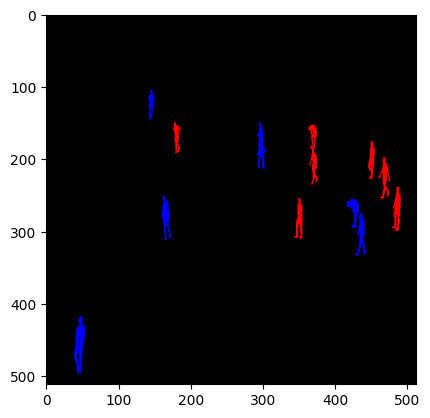

In [20]:
plt.imshow(final_masks[0])

In [21]:
def encode_rgb_masks(rgb_masks):
    # Convert RGB masks to grayscale
    gray_masks = np.zeros((rgb_masks.shape[0], rgb_masks.shape[1]), dtype=np.uint8)
    
    # Define color-to-intensity mappings for each class
    color_to_intensity = {
        (0, 0, 0): 0,     # Background
        (255, 0, 0): 1,   # Class 1
        (0, 0, 255): 3    # Class 3
        # Add more mappings for additional classes if needed
    }
    
    # Encode RGB masks into grayscale
    for i in range(rgb_masks.shape[0]):
        for j in range(rgb_masks.shape[1]):
            color = tuple(rgb_masks[i, j])
            gray_masks[i, j] = color_to_intensity.get(color, 0)  # Assign intensity based on color mapping
    
    return gray_masks

In [22]:
num_classes = 3

In [23]:
# Normalize input images
encoded_masks= []
for i in range(len(final_masks)):
    encoded_masks.append(encode_rgb_masks(final_masks[i]))

In [88]:
# Prepare the data
input_images = np.array(images)
input_masks = np.array(encoded_masks)

In [90]:
'''
def convert_rgb_to_grayscale(rgb_image):
    return np.dot(rgb_image[...,:3], [0.2989, 0.5870, 0.1140])
'''
input_images = input_images / 255.0


In [101]:
# Split data into training and validation sets
split_ratio = 0.7
split_index = int(len(input_images) * split_ratio)

train_images = input_images[:split_index]
train_masks = input_masks[:split_index]

val_images = input_images[split_index:]
val_masks = input_masks[split_index:]

split_ratio2 = 0.5
split_index2 = int(len(val_images) * split_ratio)

print(split_index2)
validation_images = val_images[:split_index2]
validation_masks = val_masks[:split_index2]

test_images = val_images[split_index2:]
test_masks = val_masks[split_index2:]


107


In [134]:
# Convert grayscale masks to one-hot encoded format
num_classes = 3  # Replace with the actual number of classes
train_masks_encoded = np.zeros((len(train_masks), 512, 512, num_classes), dtype=np.float32)
validation_masks_encoded = np.zeros((len(validation_masks), 512, 512, num_classes), dtype=np.float32)

test_masks_encoded = np.zeros((len(test_masks), 512, 512, num_classes), dtype=np.float32)

for i in range(len(train_masks)):
    train_masks_encoded[i] = tf.one_hot(train_masks[i], num_classes)

for i in range(len(validation_masks)):
    validation_masks_encoded[i] = tf.one_hot(validation_masks[i], num_classes)
    
for i in range(len(test_masks)):
    test_masks_encoded[i] = tf.one_hot(test_masks[i], num_classes)

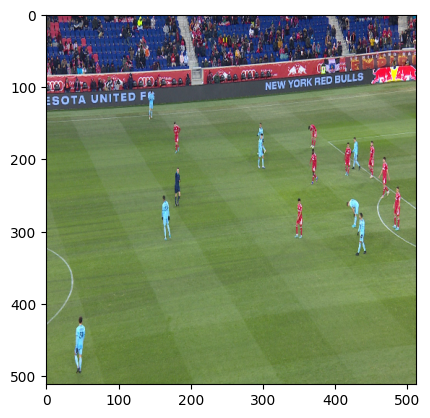

In [91]:
plt.imshow(input_images[0])

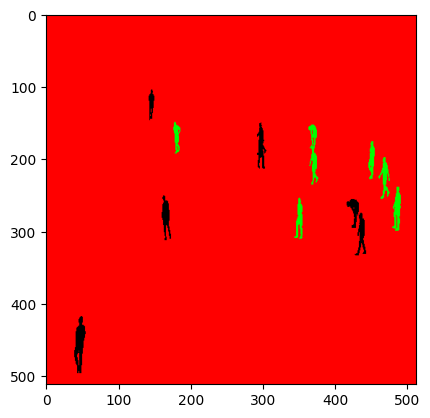

In [104]:
#plt.imshow(visualize_mask(input_masks[0]))
plt.imshow(train_masks_encoded[0])

In [109]:
train_masks_encoded[0].shape

(512, 512, 3)

In [105]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def unet_model(input_shape, num_classes=3):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(decode4)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

### U-Net Model

In [110]:
# Create and compile the model
model = unet_model((512, 512, 3))
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

max_norm = 1.0

optimizer = tf.keras.optimizers.Adam(clipvalue=max_norm)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
epochs = 5
batch_size = 4
unet_history = model.fit(train_images, train_masks_encoded, validation_data=(validation_images, validation_masks_encoded),
          batch_size=batch_size, epochs=epochs)

Epoch 1/5
90/90 [==============================] - 3740s 42s/step - loss: 0.1846 - accuracy: 0.9685 - val_loss: 0.6710 - val_accuracy: 0.6725
Epoch 2/5
90/90 [==============================] - 3750s 42s/step - loss: 0.0352 - accuracy: 0.9953 - val_loss: 0.0594 - val_accuracy: 0.9927
Epoch 3/5
90/90 [==============================] - 3688s 41s/step - loss: 0.0234 - accuracy: 0.9964 - val_loss: 0.0450 - val_accuracy: 0.9927
Epoch 4/5
90/90 [==============================] - 3683s 41s/step - loss: 0.0179 - accuracy: 0.9970 - val_loss: 0.0222 - val_accuracy: 0.9940
Epoch 5/5
90/90 [==============================] - 3728s 41s/step - loss: 0.0140 - accuracy: 0.9971 - val_loss: 0.0146 - val_accuracy: 0.9972


In [112]:
model.save('unet1-football-asma.h5')

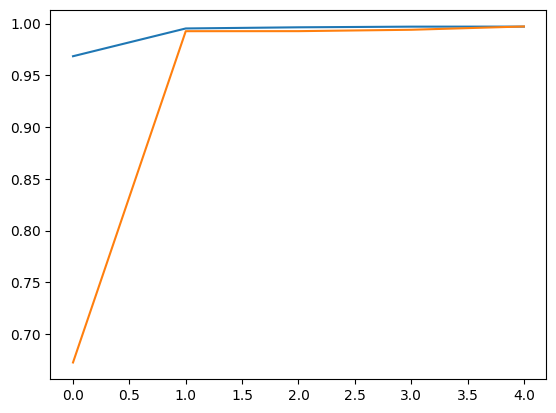

In [113]:
plt.plot(unet_history.history["accuracy"])
plt.plot(unet_history.history["val_accuracy"])

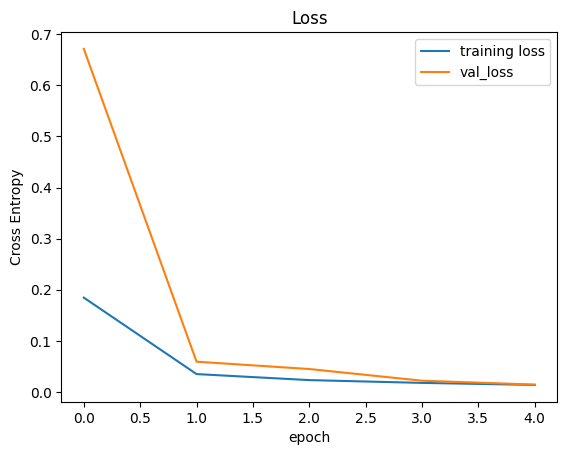

In [114]:
plt.plot(unet_history.history["loss"])
plt.plot(unet_history.history["val_loss"])
plt.ylabel('Cross Entropy')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(('training loss','val_loss'),loc='upper right')

In [155]:

validation_loss, validation_accuracy = model.evaluate(validation_images, validation_masks_encoded, batch_size = 4)


27/27 [==============================] - 312s 12s/step - loss: 0.0146 - accuracy: 0.9972


In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_masks_encoded, batch_size = 4)

In [135]:
train_accuracy = unet_history.history['accuracy'][-1]
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 99.71%
Model Accuracy on the Validation Dataset: 99.72%
Model Accuracy on the Test Dataset: 99.7%


In [ ]:

predicted_mask = model.predict(test_images[0])

In [138]:
unet_predict = model.predict(test_images)

2/2 [==============================] - 127s 40s/step


In [153]:
def show_result(og, unet,  target):
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net Predicted Mask")
    axs[1].imshow(unet)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

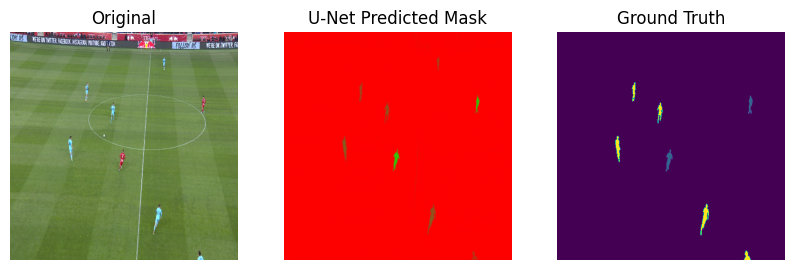

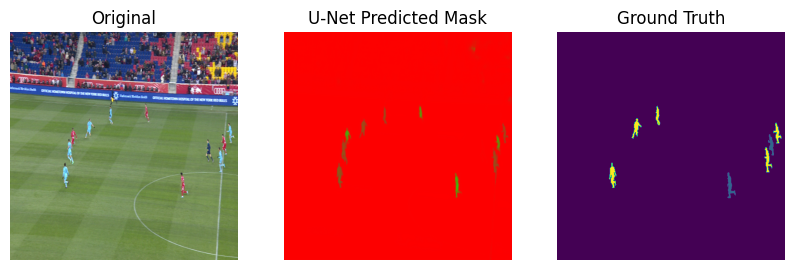

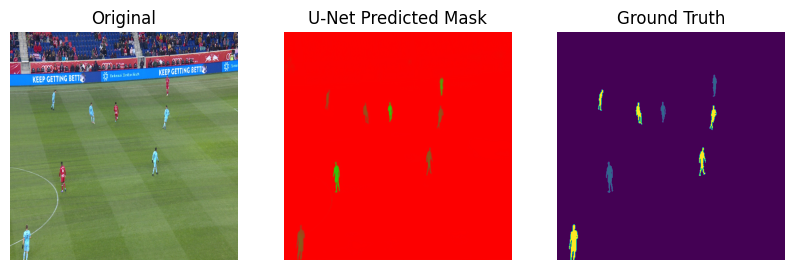

In [154]:
show_test_idx = random.sample(range(47), 3)
for idx in show_test_idx: 
    show_result(test_images[idx], unet_predict[idx], test_masks[idx])

In [156]:
show_test_idx

[3, 18, 13]